In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('max_rows', 300)
pd.set_option('max_columns', 300)

import os
import glob

In [2]:
# data directory
data_dir = "/home/ash/Documents/Projects/kaggle/ORVP/data/"
# DATA_DIR = "/home/ash/Documents/Projects/kaggle/ORVP/data/"


In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file, ftype="csv"):
    """create a dataframe and optimize its memory usage"""
    if ftype=="csv":
        df = pd.read_csv(file)
    if ftype=="parquet":
        df = pd.read_parquet(file)
    df = reduce_mem_usage(df)
    return df

## Functions for preprocessing

In [4]:
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    return wap
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    return wap

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

def count_unique(series):
    return len(np.unique(series))

## Main function for preprocessing book data

In [5]:
def preprocessor_book(file_path):
    df = import_data(file_path, "parquet")
    #calculate return etc
    df['wap'] = calc_wap1(df)
    df['log_return'] = df.groupby('time_id')['wap'].apply(log_return)
    
    df['wap2'] = calc_wap2(df)
    df['log_return2'] = df.groupby('time_id')['wap2'].apply(log_return)
    
    df['wap_balance'] = abs(df['wap'] - df['wap2'])
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    #dict for aggregate
    create_feature_dict = {
        'log_return':[realized_volatility],
        'log_return2':[realized_volatility],
        'wap_balance':[np.mean],
        'price_spread':[np.mean],
        'bid_spread':[np.mean],
        'ask_spread':[np.mean],
        'volume_imbalance':[np.mean],
        'total_volume':[np.mean],
        'wap':[np.mean],
            }

    #####groupby / all seconds
    df_feature = pd.DataFrame(df.groupby(['time_id']).agg(create_feature_dict)).reset_index()
    
    df_feature.columns = ['_'.join(col) for col in df_feature.columns] #time_id is changed to time_id_
        
    ######groupby / last XX seconds
    last_seconds = [300, 150]
    
    for second in last_seconds:
        second = 600 - second 
    
        df_feature_sec = pd.DataFrame(df.query(f'seconds_in_bucket >= {second}').groupby(['time_id']).agg(create_feature_dict)).reset_index()

        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns] #time_id is changed to time_id_
     
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))

        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    #create row_id
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['time_id_'],axis=1)
    
    return df_feature

## Main function for preprocessing trade data

In [6]:
def preprocessor_trade(file_path):
    df = import_data(file_path, "parquet")
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    aggregate_dictionary = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(aggregate_dictionary)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]

    
    ######groupby / last XX seconds
    last_seconds = [300, 150]
    
    for second in last_seconds:
        second = 600 - second
    
        df_feature_sec = df.query(f'seconds_in_bucket >= {second}').groupby('time_id').agg(aggregate_dictionary)
        df_feature_sec = df_feature_sec.reset_index()
        
        df_feature_sec.columns = ['_'.join(col) for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix('_' + str(second))
        
        df_feature = pd.merge(df_feature,df_feature_sec,how='left',left_on='time_id_',right_on=f'time_id__{second}')
        df_feature = df_feature.drop([f'time_id__{second}'],axis=1)
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

## Combined preprocessor function

In [7]:
def preprocessor(list_stock_ids, is_train = True):
    from joblib import Parallel, delayed # parallel computing to save time
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if is_train:
            file_path_book = data_dir + "book_train.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_train.parquet/stock_id=" + str(stock_id)
        else:
            file_path_book = data_dir + "book_test.parquet/stock_id=" + str(stock_id)
            file_path_trade = data_dir + "trade_test.parquet/stock_id=" + str(stock_id)
            
        df_tmp = pd.merge(preprocessor_book(file_path_book),preprocessor_trade(file_path_trade),on='row_id',how='left')
     
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
        delayed(for_joblib)(stock_id) for stock_id in list_stock_ids
        )

    df =  pd.concat(df,ignore_index = True)
    return df


## Training set

In [8]:
train = pd.read_csv(data_dir + 'train.csv')
train_ids = train.stock_id.unique()
df_train = preprocessor(list_stock_ids= train_ids, is_train = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Memory usage of dataframe is 31.50 MB
Memory usage of dataframe is 33.71 MB
Memory usage after optimization is: 19.25 MB
Decreased by 38.9%
Memory usage after optimization is: 20.60 MB
Decreased by 38.9%
Memory usage of dataframe is 43.58 MB
Memory usage of dataframe is 51.76 MB
Memory usage of dataframe is 32.77 MB
Memory usage of dataframe is 36.87 MB
Memory usage of dataframe is 51.82 MB
Memory usage after optimization is: 20.03 MB
Decreased by 38.9%
Memory usage of dataframe is 54.11 MB
Memory usage after optimization is: 34.50 MB
Decreased by 33.3%
Memory usage after optimization is: 36.32 MB
Decreased by 16.7%
Memory usage of dataframe is 65.34 MB
Memory usage of dataframe is 41.40 MB
Memory usage after optimization is: 43.18 MB
Decreased by 16.7%
Memory usage after optimization is: 22.53 MB
Decreased by 38.9%
Memory usage of dataframe is 43.04 MB
Memory usage after optimization is: 45.09 MB
Decreased by 16.7%
Memory usage after optimization is: 54.45 MB
Decreased by 16.7%
Memory

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min


Memory usage of dataframe is 34.35 MB
Memory usage after optimization is: 20.99 MB
Decreased by 38.9%
Memory usage of dataframe is 59.02 MB
Memory usage after optimization is: 49.18 MB
Decreased by 16.7%
Memory usage of dataframe is 73.61 MB
Memory usage after optimization is: 61.34 MB
Decreased by 16.7%
Memory usage of dataframe is 49.47 MB
Memory usage after optimization is: 35.73 MB
Decreased by 27.8%
Memory usage of dataframe is 78.78 MB
Memory usage after optimization is: 65.65 MB
Decreased by 16.7%
Memory usage of dataframe is 68.31 MB
Memory usage of dataframe is 74.25 MB
Memory usage of dataframe is 71.55 MB
Memory usage after optimization is: 56.93 MB
Decreased by 16.7%
Memory usage after optimization is: 61.87 MB
Decreased by 16.7%
Memory usage after optimization is: 59.62 MB
Decreased by 16.7%
Memory usage of dataframe is 42.87 MB
Memory usage after optimization is: 30.96 MB
Decreased by 27.8%
Memory usage of dataframe is 73.77 MB
Memory usage after optimization is: 61.47 MB

[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  3.7min finished


In [9]:
train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
train = train[['row_id','target']]
df_train = train.merge(df_train, on = ['row_id'], how = 'left')
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap_mean_450,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450
0,0-5,0.004136,0.005160,0.007724,0.000411,0.000815,0.000278,-0.000146,134.894040,323.496689,1.003766,0.003357,0.005039,0.000396,0.000819,0.000309,-0.000176,137.158273,294.928058,1.003837,0.002340,0.003989,0.000410,0.000858,0.000359,-0.000072,141.470588,263.941176,1.003589,0.003088,40.0,3179.0,2.750000,0.002392,21.0,1587.0,2.571429,0.001381,14.0,1042.0,2.642857
1,0-11,0.001445,0.002300,0.003533,0.000276,0.000356,0.000127,-0.000313,142.050000,411.450000,1.000145,0.002226,0.003036,0.000281,0.000391,0.000161,-0.000238,135.513043,484.521739,1.000325,0.002009,0.002453,0.000382,0.000488,0.000325,-0.000163,97.685185,447.981481,1.000548,0.001381,30.0,1289.0,1.900000,0.000977,16.0,900.0,2.250000,0.000977,10.0,828.0,2.200000
2,0-16,0.002168,0.002748,0.004967,0.000388,0.000722,0.000195,-0.000281,141.414894,416.351064,0.999477,0.001654,0.002845,0.000403,0.000698,0.000136,-0.000237,144.147059,455.235294,0.998668,0.001595,0.002754,0.000408,0.000667,0.000211,-0.000200,156.113636,459.113636,0.998248,0.002014,25.0,2161.0,2.720000,0.001292,12.0,1189.0,3.166667,0.001196,9.0,1085.0,3.666667
3,0-31,0.002195,0.002607,0.003607,0.000314,0.000782,0.000142,-0.000224,146.216667,435.266667,0.998787,0.001621,0.002663,0.000298,0.000766,0.000111,-0.000166,144.698113,418.169811,0.998409,0.000857,0.001533,0.000333,0.000978,0.000136,0.000000,146.000000,540.000000,0.998150,0.001381,15.0,1962.0,3.933333,0.001092,9.0,1556.0,5.111111,0.000690,3.0,514.0,3.666667
4,0-62,0.001747,0.002442,0.003435,0.000327,0.000414,0.000191,-0.000069,123.846591,343.221591,0.999612,0.002091,0.002395,0.000348,0.000544,0.000115,-0.000099,99.449438,407.584270,0.999448,0.001804,0.001349,0.000504,0.000720,0.000041,-0.000149,117.000000,391.944444,0.999424,0.001292,22.0,1791.0,4.045455,0.000000,11.0,1219.0,4.909091,0.000000,4.0,43.0,3.500000


## Test set

In [10]:
test = pd.read_csv(data_dir + 'test.csv')
test_ids = test.stock_id.unique()
df_test = preprocessor(list_stock_ids= test_ids, is_train = False)

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 26.7%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 14.1%


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished


In [11]:
df_test = test.merge(df_test, on = ['row_id'], how = 'left')

## Target encoding by stock_id

In [12]:
from sklearn.model_selection import KFold
#stock_id target encoding
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])

stock_id_target_mean = df_train.groupby('stock_id')['target'].mean() 
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean) # test_set

#training
tmp = np.repeat(np.nan, df_train.shape[0])
kf = KFold(n_splits = 10, shuffle=True,random_state = 19911109)
for idx_1, idx_2 in kf.split(df_train):
    target_mean = df_train.iloc[idx_1].groupby('stock_id')['target'].mean()

    tmp[idx_2] = df_train['stock_id'].iloc[idx_2].map(target_mean)
df_train['stock_id_target_enc'] = tmp

## Model Building

In [13]:
df_train.head()

,row_id,target,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap_mean_450,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,stock_id,stock_id_target_enc
0,0-5,0.004136,0.005160,0.007724,0.000411,0.000815,0.000278,-0.000146,134.894040,323.496689,1.003766,0.003357,0.005039,0.000396,0.000819,0.000309,-0.000176,137.158273,294.928058,1.003837,0.002340,0.003989,0.000410,0.000858,0.000359,-0.000072,141.470588,263.941176,1.003589,0.003088,40.0,3179.0,2.750000,0.002392,21.0,1587.0,2.571429,0.001381,14.0,1042.0,2.642857,0,0.004041
1,0-11,0.001445,0.002300,0.003533,0.000276,0.000356,0.000127,-0.000313,142.050000,411.450000,1.000145,0.002226,0.003036,0.000281,0.000391,0.000161,-0.000238,135.513043,484.521739,1.000325,0.002009,0.002453,0.000382,0.000488,0.000325,-0.000163,97.685185,447.981481,1.000548,0.001381,30.0,1289.0,1.900000,0.000977,16.0,900.0,2.250000,0.000977,10.0,828.0,2.200000,0,0.004039
2,0-16,0.002168,0.002748,0.004967,0.000388,0.000722,0.000195,-0.000281,141.414894,416.351064,0.999477,0.001654,0.002845,0.000403,0.000698,0.000136,-0.000237,144.147059,455.235294,0.998668,0.001595,0.002754,0.000408,0.000667,0.000211,-0.000200,156.113636,459.113636,0.998248,0.002014,25.0,2161.0,2.720000,0.001292,12.0,1189.0,3.166667,0.001196,9.0,1085.0,3.666667,0,0.004041
3,0-31,0.002195,0.002607,0.003607,0.000314,0.000782,0.000142,-0.000224,146.216667,435.266667,0.998787,0.001621,0.002663,0.000298,0.000766,0.000111,-0.000166,144.698113,418.169811,0.998409,0.000857,0.001533,0.000333,0.000978,0.000136,0.000000,146.000000,540.000000,0.998150,0.001381,15.0,1962.0,3.933333,0.001092,9.0,1556.0,5.111111,0.000690,3.0,514.0,3.666667,0,0.004013
4,0-62,0.001747,0.002442,0.003435,0.000327,0.000414,0.000191,-0.000069,123.846591,343.221591,0.999612,0.002091,0.002395,0.000348,0.000544,0.000115,-0.000099,99.449438,407.584270,0.999448,0.001804,0.001349,0.000504,0.000720,0.000041,-0.000149,117.000000,391.944444,0.999424,0.001292,22.0,1791.0,4.045455,0.000000,11.0,1219.0,4.909091,0.000000,4.0,43.0,3.500000,0,0.004032


In [14]:
df_test.head()

,stock_id,time_id,row_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap_mean_450,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,stock_id_target_enc
0,0,4,0-4,0.000448,0.0,0.000362,0.000977,0.000488,0.0,164.666667,350.666667,1.000615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
1,0,32,0-32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,34,0-34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [15]:
DO_FEAT_IMP = False
if len(df_test)==3:
    DO_FEAT_IMP = True

## LightGBM

In [16]:
import lightgbm as lgbm

In [17]:
# ref https://www.kaggle.com/corochann/permutation-importance-for-feature-selection-part1
def calc_model_importance(model, feature_names=None, importance_type='gain'):
    importance_df = pd.DataFrame(model.feature_importance(importance_type=importance_type),
                                 index=feature_names,
                                 columns=['importance']).sort_values('importance')
    return importance_df


def plot_importance(importance_df, title='',
                    save_filepath=None, figsize=(8, 12)):
    fig, ax = plt.subplots(figsize=figsize)
    importance_df.plot.barh(ax=ax)
    if title:
        plt.title(title)
    plt.tight_layout()
    if save_filepath is None:
        plt.show()
    else:
        plt.savefig(save_filepath)
    plt.close()

In [18]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [19]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [20]:
X.to_pickle("X.pkl")
y.to_pickle("y.pkl")

,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap_mean_450,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,stock_id,stock_id_target_enc
0,0.005160,0.007724,0.000411,0.000815,0.000278,-0.000146,134.894040,323.496689,1.003766,0.003357,0.005039,0.000396,0.000819,0.000309,-0.000176,137.158273,294.928058,1.003837,0.002340,0.003989,0.000410,0.000858,0.000359,-0.000072,141.470588,263.941176,1.003589,0.003088,40.0,3179.0,2.750000,0.002392,21.0,1587.0,2.571429,0.001381,14.0,1042.0,2.642857,0,0.004041
1,0.002300,0.003533,0.000276,0.000356,0.000127,-0.000313,142.050000,411.450000,1.000145,0.002226,0.003036,0.000281,0.000391,0.000161,-0.000238,135.513043,484.521739,1.000325,0.002009,0.002453,0.000382,0.000488,0.000325,-0.000163,97.685185,447.981481,1.000548,0.001381,30.0,1289.0,1.900000,0.000977,16.0,900.0,2.250000,0.000977,10.0,828.0,2.200000,0,0.004039
2,0.002748,0.004967,0.000388,0.000722,0.000195,-0.000281,141.414894,416.351064,0.999477,0.001654,0.002845,0.000403,0.000698,0.000136,-0.000237,144.147059,455.235294,0.998668,0.001595,0.002754,0.000408,0.000667,0.000211,-0.000200,156.113636,459.113636,0.998248,0.002014,25.0,2161.0,2.720000,0.001292,12.0,1189.0,3.166667,0.001196,9.0,1085.0,3.666667,0,0.004041
3,0.002607,0.003607,0.000314,0.000782,0.000142,-0.000224,146.216667,435.266667,0.998787,0.001621,0.002663,0.000298,0.000766,0.000111,-0.000166,144.698113,418.169811,0.998409,0.000857,0.001533,0.000333,0.000978,0.000136,0.000000,146.000000,540.000000,0.998150,0.001381,15.0,1962.0,3.933333,0.001092,9.0,1556.0,5.111111,0.000690,3.0,514.0,3.666667,0,0.004013
4,0.002442,0.003435,0.000327,0.000414,0.000191,-0.000069,123.846591,343.221591,0.999612,0.002091,0.002395,0.000348,0.000544,0.000115,-0.000099,99.449438,407.584270,0.999448,0.001804,0.001349,0.000504,0.000720,0.000041,-0.000149,117.000000,391.944444,0.999424,0.001292,22.0,1791.0,4.045455,0.000000,11.0,1219.0,4.909091,0.000000,4.0,43.0,3.500000,0,0.004032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428927,0.004299,0.007021,0.000417,0.000867,0.000088,-0.000265,161.638710,406.045161,0.999608,0.003300,0.004453,0.000290,0.000885,0.000093,-0.000117,150.471831,379.443662,0.999407,0.001806,0.002767,0.000275,0.000710,0.000130,-0.000195,119.466667,347.333333,0.999235,0.002890,37.0,2570.0,2.783784,0.001891,18.0,796.0,2.055556,0.001619,12.0,491.0,1.833333,126,0.005312
428928,0.004724,0.006109,0.000322,0.000458,0.000109,-0.000232,150.578475,243.322870,1.002453,0.003683,0.004205,0.000271,0.000621,0.000130,-0.000195,153.819048,242.561905,1.003513,0.003016,0.003384,0.000340,0.000666,0.000145,-0.000325,121.203704,232.462963,1.004172,0.002930,43.0,2323.0,3.418605,0.002184,20.0,1107.0,3.550000,0.001692,13.0,326.0,1.769231,126,0.005327
428929,0.004563,0.008245,0.000526,0.000862,0.000210,-0.000172,254.406250,348.093750,1.001144,0.003821,0.007807,0.000653,0.000806,0.000275,-0.000234,249.401198,343.592814,1.001329,0.002536,0.004760,0.000792,0.000807,0.000393,-0.000269,285.218391,344.459770,1.001651,0.003010,35.0,3740.0,2.800000,0.00

In [ ]:
X = pd.read_pickle("X.pkl")
y = pd.read_pickle("y.pkl")

In [21]:
def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

def feval_RMSPE(preds, lgbm_train):
    labels = lgbm_train.get_label()
    return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False



### Hyperparameter tuning

In [22]:
# RandomizedSearchCV

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=314)
# from scipy.stats import randint as sp_randint
# from scipy.stats import uniform as sp_uniform
# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), # alias to bagging fraction
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6), # alias to feature_fraction
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100], # alias to lambda_l1
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],  # alias to lambda_l2
#             }

# #This parameter defines the number of HP points to be tested
# n_HP_points_to_test = 200

# from sklearn.model_selection import RandomizedSearchCV
# #n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
# reg = lgbm.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=5000)
# gs = RandomizedSearchCV(
#     estimator=reg, param_distributions=param_test, 
#     n_iter=n_HP_points_to_test,
#     scoring='neg_mean_squared_error',
#     cv=3,
#     refit=True,
#     random_state=314,
#     verbose=True)

# fit_params={"early_stopping_rounds":30, 
#             "eval_metric" : 'rmse', 
#             "eval_set" : [(X_test,y_test)],
#             'eval_names': ['valid'],
#             #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
#             'verbose': 100,
#             'categorical_feature': 'auto'}
# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [23]:
from bayes_opt import BayesianOptimization
import warnings

warnings.filterwarnings("ignore")

def bayesion_opt_lgbm(X, y, init_iter=3, n_iters=7, random_state=11, seed = 101, num_iterations = 100, nFold=5):
#     X['stock_id'] = X['stock_id'].astype('category')
    dtrain = lgbm.Dataset(data=X, label=y, categorical_feature=['stock_id'])

    def rmspe(y_true, y_pred):
        return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

    def feval_RMSPE(preds, dtrain):
        labels = dtrain.get_label()
        return 'RMSPE', round(rmspe(y_true = labels, y_pred = preds),5), False
    
    # Objective Function
    def hyp_lgbm(num_leaves, feature_fraction, bagging_fraction, max_depth, reg_alpha, reg_lambda):
        # Default parameters
        params = {'application':'regression',
                  'num_iterations': num_iterations,
                  'learning_rate':0.01, 
                  'early_stopping_round':30,
                  'metric':'feval_RMSPE',
                  'verbose': -1,
                  } 
        
        # Parameters for tuning
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
#         params['min_split_gain'] = min_split_gain
#         params['min_child_weight'] = min_child_weight
        params['reg_alpha'] = reg_alpha
        params['reg_lambda'] = reg_lambda
        
        
        # Run the model with cv
        cv_results = lgbm.cv(params, dtrain, nfold=nFold, seed=seed,categorical_feature=['stock_id'], stratified=False,
                            verbose_eval =False, feval=feval_RMSPE)
#         print('RMSPE-mean-cv = ' + str(np.mean(cv_results['RMSPE-mean'])))
        return -np.max(cv_results['RMSPE-mean'])
    
    # Parameter domain space-- Range of hyperparameters 
    pds = {'num_leaves': (40, 100),
            'feature_fraction': (0.8, 1),
            'bagging_fraction': (0.8, 1),
            'max_depth': (17, 25),
#             'min_split_gain': (0.001, 0.1),
#             'min_child_weight': (10, 25),
            'reg_alpha': (1, 5), # alias to lambda_l1
            'reg_lambda': (1, 5),  # alias to lambda_l2,
            }

    # Surrogate model
    optimizer = BayesianOptimization(hyp_lgbm, pds, random_state=random_state)
                                    
    # Optimize
    optimizer.maximize(init_points=init_iter, n_iter=n_iters, acq='ei')
    
    # output optimization process
#     if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
        
#     return optimizer.max['params']
    return optimizer

## call the optimizer    
optimizer = bayesion_opt_lgbm(X, y, init_iter=5, n_iters=7, random_state=11, seed = 101, num_iterations = 100, nFold=5)


|   iter    |  target   | baggin... | featur... | max_depth | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        | -1.102    |  0.8361   |  0.8039   |  20.71    |  83.5     |  2.681    |  2.942    |
|  2        | -1.102    |  0.8026   |  0.8975   |  24.53    |  91.05    |  3.92     |  1.435    |
|  3        | -1.102    |  0.9788   |  0.9714   |  18.32    |  77.94    |  1.082    |  1.467    |
|  4        | -1.102    |  0.8633   |  0.8316   |  23.07    |  89.1     |  2.378    |  2.275    |
|  5        | -1.102    |  0.8223   |  0.8168   |  22.7     |  75.97    |  1.223    |  2.919    |
|  6        | -1.102    |  0.8037   |  0.9853   |  17.69    |  72.2     |  1.852    |  2.89     |
|  7        | -1.102    |  1.0      |  1.0      |  20.9     |  77.14    |  3.716    |  1.0      |
|  8        | -1.102    |  0.9544   |  0.9081   |  17.73    |  77.57    |  1.224    |  1.225    |
|  9        | -1.102

In [24]:
optimizer.max

{'target': -1.10169,
 'params': {'bagging_fraction': 0.8485792876252881,
  'feature_fraction': 0.8587876059831933,
  'max_depth': 17.0,
  'num_leaves': 78.5719590226306,
  'reg_alpha': 1.0,
  'reg_lambda': 3.1784947055735335}}

In [25]:
fit_params ={
            "objective": "rmse", 
            "metric": "rmse", 
            "boosting_type": "gbdt",
            'early_stopping_rounds': 30,
#             'device_type': 'gpu',
            'random_seed': 42
            
            }
opt_params = fit_params
opt_params.update(optimizer.max['params'])
opt_params["max_depth"] = int(opt_params["max_depth"])
opt_params["num_leaves"] = int(opt_params["num_leaves"])
print(opt_params)

{'objective': 'rmse', 'metric': 'rmse', 'boosting_type': 'gbdt', 'early_stopping_rounds': 30, 'random_seed': 42, 'bagging_fraction': 0.8485792876252881, 'feature_fraction': 0.8587876059831933, 'max_depth': 17, 'num_leaves': 78, 'reg_alpha': 1.0, 'reg_lambda': 3.1784947055735335}


### Cross Validation

In [26]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [27]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=19901028, shuffle=True)
oof = pd.DataFrame()                 # out-of-fold result
models = []                          # models
scores = 0.0                         # validation score

gain_importance_list = []
split_importance_list = []
shap_importance_list = []

In [28]:
%%time
import shap

for fold, (trn_idx, val_idx) in enumerate(kf.split(X, y)):

    print("Fold :", fold+1)
    
    # create dataset
    X_train, y_train = X.loc[trn_idx], y[trn_idx]
    X_valid, y_valid = X.loc[val_idx], y[val_idx]
    
    #RMSPE weight
    weights = 1/np.square(y_train)
    lgbm_train = lgbm.Dataset(X_train,y_train,weight = weights)

    weights = 1/np.square(y_valid)
    lgbm_valid = lgbm.Dataset(X_valid,y_valid,reference = lgbm_train,weight = weights)
    
    # model 
    model = lgbm.train(params=opt_params,
                      train_set=lgbm_train,
                      valid_sets=[lgbm_train, lgbm_valid],
                      num_boost_round=5000,         
                      feval=feval_RMSPE,
                      verbose_eval=-1,
                      categorical_feature = ['stock_id'], 
                      callbacks=[lgbm.reset_parameter(learning_rate=learning_rate_010_decay_power_0995)],                
                     )
    
    # validation 
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    RMSPE = round(rmspe(y_true = y_valid, y_pred = y_pred),3)
    print(f'Performance of the　prediction: , RMSPE: {RMSPE}')

    #keep scores and models
    scores += RMSPE / 5
    models.append(model)
    print("*" * 100)
    
    # --- calc model feature importance ---
    if DO_FEAT_IMP:    
        feature_names = X_train.columns.values.tolist()
        gain_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='gain')
        gain_importance_list.append(gain_importance_df)

        split_importance_df = calc_model_importance(
            model, feature_names=feature_names, importance_type='split')
        split_importance_list.append(split_importance_df)

        # Explain model predictions using shap library:
        explainer = shap.TreeExplainer(model)
        shap_importance_list.append(explainer.shap_values(X_valid))

Fold : 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10209
[LightGBM] [Info] Number of data points in the train set: 386038, number of used features: 41
[LightGBM] [Info] Start training from score 0.001803
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[157]	training's rmse: 0.00048997	training's RMSPE: 0.22653	valid_1's rmse: 0.000518024	valid_1's RMSPE: 0.24195
Performance of the　prediction: , RMSPE: 0.242
****************************************************************************************************
Fold : 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10208
[LightGBM] [Info] Number of data points in the train set: 386038, number of use

In [29]:
scores

0.48900000000000005

In [30]:
def calc_mean_importance(importance_df_list):
    mean_importance = np.mean(
        np.array([df['importance'].values for df in importance_df_list]), axis=0)
    mean_df = importance_df_list[0].copy()
    mean_df['importance'] = mean_importance
    return mean_df

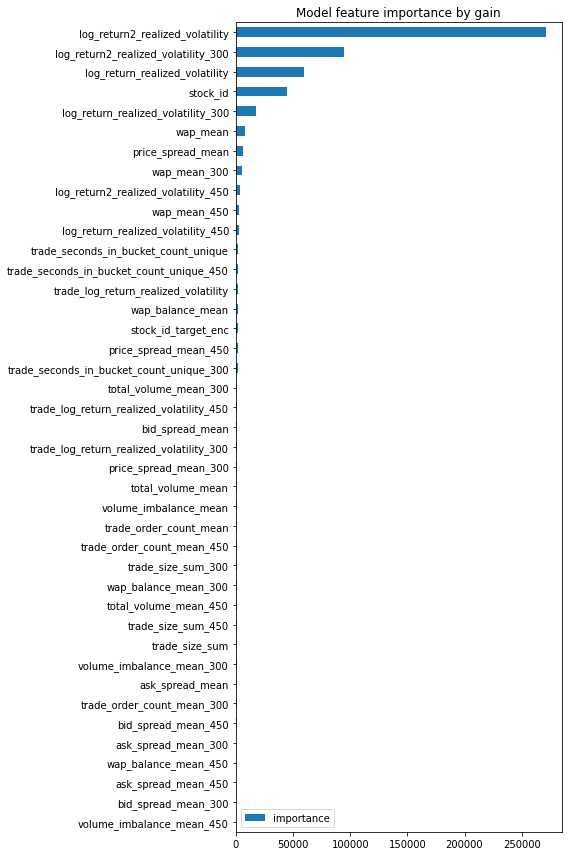

In [31]:
if DO_FEAT_IMP:
    mean_gain_df = calc_mean_importance(gain_importance_list)
    plot_importance(mean_gain_df, title='Model feature importance by gain')
    mean_gain_df = mean_gain_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_gain_df.to_csv('gain_importance_mean.csv', index=False)

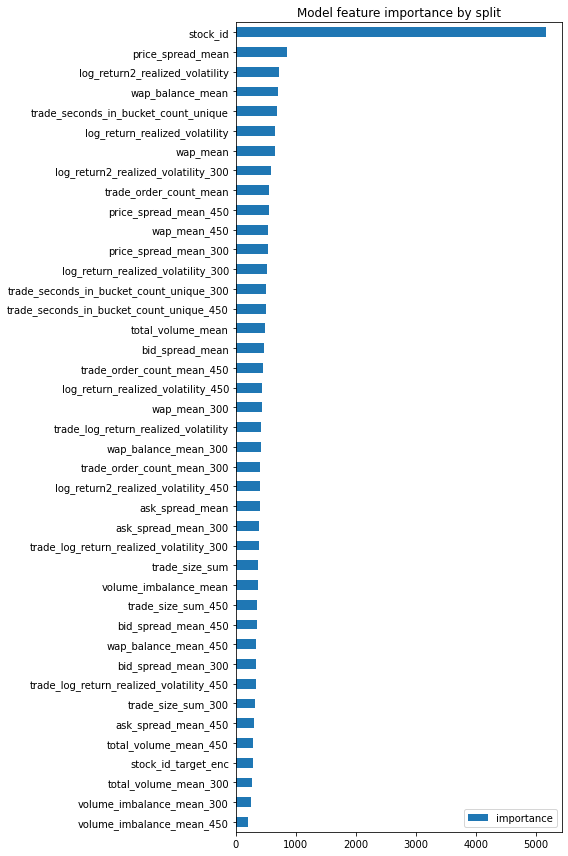

In [32]:
if DO_FEAT_IMP:
    mean_split_df = calc_mean_importance(split_importance_list)
    plot_importance(mean_split_df, title='Model feature importance by split')
    mean_split_df = mean_split_df.reset_index().rename(columns={'index': 'feature_names'})
    mean_split_df.to_csv('split_importance_mean.csv', index=False)

# Test set

In [43]:
df_test.columns

Index(['stock_id', 'time_id', 'row_id', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_450',
       'log_return2_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap_mean_450',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
    

In [35]:
df_train.columns

Index(['row_id', 'target', 'log_return_realized_volatility',
       'log_return2_realized_volatility', 'wap_balance_mean',
       'price_spread_mean', 'bid_spread_mean', 'ask_spread_mean',
       'volume_imbalance_mean', 'total_volume_mean', 'wap_mean',
       'log_return_realized_volatility_300',
       'log_return2_realized_volatility_300', 'wap_balance_mean_300',
       'price_spread_mean_300', 'bid_spread_mean_300', 'ask_spread_mean_300',
       'volume_imbalance_mean_300', 'total_volume_mean_300', 'wap_mean_300',
       'log_return_realized_volatility_450',
       'log_return2_realized_volatility_450', 'wap_balance_mean_450',
       'price_spread_mean_450', 'bid_spread_mean_450', 'ask_spread_mean_450',
       'volume_imbalance_mean_450', 'total_volume_mean_450', 'wap_mean_450',
       'trade_log_return_realized_volatility',
       'trade_seconds_in_bucket_count_unique', 'trade_size_sum',
       'trade_order_count_mean', 'trade_log_return_realized_volatility_300',
       'trade_sec

In [36]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id', 'row_id'], axis = 1)

In [37]:
X_test

,stock_id,log_return_realized_volatility,log_return2_realized_volatility,wap_balance_mean,price_spread_mean,bid_spread_mean,ask_spread_mean,volume_imbalance_mean,total_volume_mean,wap_mean,log_return_realized_volatility_300,log_return2_realized_volatility_300,wap_balance_mean_300,price_spread_mean_300,bid_spread_mean_300,ask_spread_mean_300,volume_imbalance_mean_300,total_volume_mean_300,wap_mean_300,log_return_realized_volatility_450,log_return2_realized_volatility_450,wap_balance_mean_450,price_spread_mean_450,bid_spread_mean_450,ask_spread_mean_450,volume_imbalance_mean_450,total_volume_mean_450,wap_mean_450,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_order_count_mean,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_mean_300,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_sum_450,trade_order_count_mean_450,stock_id_target_enc
0,0,0.000448,0.0,0.000362,0.000977,0.000488,0.0,164.666667,350.666667,1.000615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,201.0,3.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004028


In [38]:
target = np.zeros(len(X_test))

#light gbm models
for model in models:
    pred = model.predict(X_test[X_valid.columns], num_iteration=model.best_iteration)
    target += pred / len(models)

In [39]:
y_pred = y_pred.assign(target = target)

In [40]:
y_pred

,row_id,target
0,0-4,0.00161
1,0-32,0.00146
2,0-34,0.00146


In [41]:
y_pred.to_csv('submission.csv',index = False)

In [42]:
#  import os
# os.listdir()